In [1]:
import numpy as np                   # Numerical computations
import pandas as pd                  # Data manipulation and analysis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.ensemble import RandomForestClassifier  # Random Forests
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Model evaluation


In [2]:
loan_data = pd.read_csv('C:\Anonymize_Loan_Default_data.csv', encoding='latin-1')


In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              38480 non-null  int64  
 1   id                      38480 non-null  int64  
 2   member_id               38480 non-null  int64  
 3   loan_amnt               38479 non-null  float64
 4   funded_amnt             38479 non-null  float64
 5   funded_amnt_inv         38479 non-null  float64
 6   term                    38480 non-null  object 
 7   int_rate                38480 non-null  float64
 8   installment             38479 non-null  float64
 9   emp_length              37487 non-null  object 
 10  home_ownership          38480 non-null  object 
 11  annual_inc              38478 non-null  float64
 12  verification_status     38480 non-null  object 
 13  issue_d                 38480 non-null  object 
 14  loan_status             38480 non-null

In [4]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


# Data Preprocessing

In [24]:
# Check data types of categorical columns before one-hot encoding
categorical_cols = ['term', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
print(loan_data[categorical_cols].dtypes)

# Perform one-hot encoding for categorical variables
loan_data = pd.get_dummies(loan_data, columns=categorical_cols, drop_first=True)


KeyError: "None of [Index(['term', 'home_ownership', 'verification_status', 'purpose',\n       'addr_state'],\n      dtype='object')] are in the [columns]"

In [19]:
# Convert 'revol_util' to string format
loan_data['revol_util'] = loan_data['revol_util'].astype(str)

# Remove '%' and convert to float
loan_data['revol_util'] = loan_data['revol_util'].str.rstrip('%').astype(float)


In [23]:

from sklearn.preprocessing import StandardScaler

# Step 1: Handling Missing Values

# Remove rows with missing values
loan_data.dropna(subset=['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment'], inplace=True)

# Impute missing values for numerical columns with the mean
numerical_cols = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
                  'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'total_pymnt',
                  'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt']
loan_data[numerical_cols] = loan_data[numerical_cols].fillna(loan_data[numerical_cols].mean())

# Impute missing values for remaining categorical columns with the mode (most frequent value)
categorical_cols = ['revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
loan_data[categorical_cols] = loan_data[categorical_cols].fillna(loan_data[categorical_cols].mode().iloc[0])

# Step 2: Data Type Conversion
# Convert 'revol_util' to a numeric format (remove '%' and convert to float)
loan_data['revol_util'] = loan_data['revol_util'].apply(lambda x: str(x).rstrip('%')).astype(float)

# Step 3: Categorical Encoding
# One-Hot Encoding for remaining categorical variables
categorical_cols = ['term', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
loan_data = pd.get_dummies(loan_data, columns=categorical_cols, drop_first=True)

# Step 4: Datetime Features
# Extract relevant information from date columns
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    loan_data[col + '_year'] = pd.to_datetime(loan_data[col]).dt.year
    loan_data[col + '_month'] = pd.to_datetime(loan_data[col]).dt.month
    loan_data[col + '_day'] = pd.to_datetime(loan_data[col]).dt.day
loan_data.drop(date_columns, axis=1, inplace=True)

# Step 5: Scaling Numerical Features (optional)

# List of numerical columns to be scaled
numerical_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc',
                  'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
                  'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                  'total_rec_int', 'last_pymnt_amnt']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical columns
loan_data[numerical_cols] = scaler.fit_transform(loan_data[numerical_cols])

# Step 6: Define Target Variable

# Assuming 'repay_fail' is your target variable and it's binary (1 for default, 0 for not default)
target_variable = 'repay_fail'


KeyError: "None of [Index(['term', 'home_ownership', 'verification_status', 'purpose',\n       'addr_state'],\n      dtype='object')] are in the [columns]"

In [20]:
# Check data types of one-hot encoded columns
print(loan_data.dtypes)

# Check unique categories and values in one-hot encoded columns
for column in loan_data.columns:
    if column.startswith("term_") or column.startswith("home_ownership_"):  # Replace with actual column prefixes
        unique_values = loan_data[column].unique()
        print(f"Column: {column}, Unique Values: {unique_values}")

# Check the size of the dataset
print("Dataset size:", loan_data.shape)

# Sample rows to verify data quality
print(loan_data.sample(5))  # Display a random sample of 5 rows


Unnamed: 0                     int64
id                             int64
member_id                      int64
loan_amnt                    float64
funded_amnt                  float64
                              ...   
last_credit_pull_d_Sep-11      uint8
last_credit_pull_d_Sep-12      uint8
last_credit_pull_d_Sep-13      uint8
last_credit_pull_d_Sep-14      uint8
last_credit_pull_d_Sep-15      uint8
Length: 1247, dtype: object
Column: term_60 months, Unique Values: [0 1]
Column: home_ownership_NONE, Unique Values: [0 1]
Column: home_ownership_OTHER, Unique Values: [0 1]
Column: home_ownership_OWN, Unique Values: [0 1]
Column: home_ownership_RENT, Unique Values: [1 0]
Dataset size: (38480, 1247)
       Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
7532         7533   355548     360311     1400.0       1225.0   
26142       26143   538056     694960     1800.0       1800.0   
28519       28520   792392     996809     5000.0       5000.0   
5443         5444   692136     8

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38480 entries, 0 to 38479
Columns: 1247 entries, Unnamed: 0 to last_credit_pull_d_Sep-15
dtypes: float64(19), int64(4), object(5), uint8(1219)
memory usage: 53.0+ MB
None

Summary Statistics for Numerical Columns:
         Unnamed: 0            id     member_id     loan_amnt   funded_amnt  \
count  38480.000000  3.848000e+04  3.848000e+04  38480.000000  38479.000000   
mean   19240.500000  6.649979e+05  8.261899e+05  11094.692698  10831.856337   
std    11108.363516  2.192322e+05  2.793531e+05   7405.322988   7146.853682   
min        1.000000  1.000000e+00  1.000000e+00      0.000000      0.000000   
25%     9620.750000  4.983645e+05  6.384620e+05   5200.000000   5100.000000   
50%    19240.500000  6.443195e+05  8.242545e+05   9750.000000   9600.000000   
75%    28860.250000  8.265608e+05  1.034706e+06  15000.000000  15000.000000   
max    38480.000000  1.077430e+06  1.314167e+06  35000.000000  35000.000000   

   

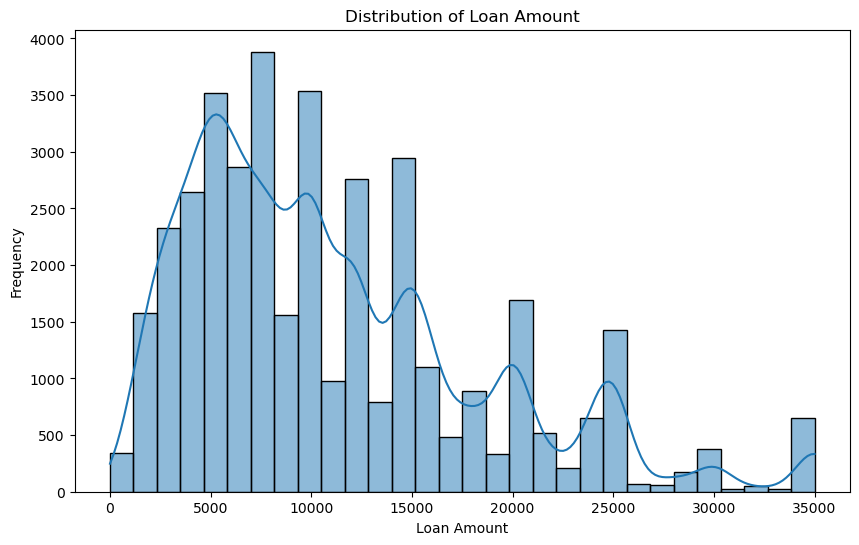

In [ ]:
# Basic dataset information
print("Dataset Information:")
print(loan_data.info())

# Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:")
print(loan_data.describe())

# Summary statistics for categorical columns
print("\nSummary Statistics for Categorical Columns:")
print(loan_data.describe(include=['object']))

# Distribution of a specific numerical column (e.g., 'loan_amnt')
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=loan_data, x='loan_amnt', bins=30, kde=True)
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix for numerical columns
correlation_matrix = loan_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()







In [1]:
# Separate features and target variable
X = loan_data.drop(columns=['repay_fail'])  # Features
y = loan_data['repay_fail']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Random Forest for feature importance
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)

# Sort features by importance
sorted_features = feature_importances.sort_values(ascending=False)

# Display the top N most important features
top_n = 10  # You can adjust this number
print("Top", top_n, "most important features:")
print(sorted_features[:top_n])

NameError: name 'loan_data' is not defined